In [2]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pyplot import figure
import time


#define plotting style that I like
style.use('fivethirtyeight')

#define constants
m_p=938.27231 #MeV
m_n=939.56563 #MeV
hbar_c=197.327053 #MeVfm

#define runtime calculator
def timer(elapsed_time):
    seconds = (time.time() - elapsed_time)
    day = seconds // (24 * 3600)
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    seconds = seconds
    print('')
    print('Total cell runtime:', "%s days, %s hours, %s minutes, %s seconds" % (day, hour, minutes, seconds) )
    print('')
    
# fucntions for k for each rxn type
def k_pp(energy):
    value=np.sqrt(((m_p**2)*(energy)*(energy+2*m_n))/(((m_p+m_n)**2)+(2*energy*m_p))) 
    k_pp=value/hbar_c 
    return k_pp
def k_np(energy):
    value=np.sqrt((1/2)*m_p*energy) 
    k_np=value/hbar_c 
    return k_np

# add k*experimental_value column
def change_np(rxn_observable):
    rxn_observable['K_experimental_value'] = rxn_observable.apply(lambda row: (row.experimental_value * k_np(row.energy)),axis=1)
    rxn_observable['K_sigma'] = rxn_observable.apply(lambda row: (row.sigma * k_np(row.energy)),axis=1)
def change_pp(rxn_observable):
    rxn_observable['K_experimental_value'] = rxn_observable.apply(lambda row: (row.experimental_value * k_pp(row.energy)),axis=1)
    rxn_observable['K_sigma'] = rxn_observable.apply(lambda row: (row.sigma * k_np(row.energy)),axis=1)

def split_and_score(size, number_of_random_states):
    test=np.zeros(number_of_random_states)
    train=np.zeros(number_of_random_states)
    for j in range(number_of_random_states):
        #split
        train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=size)
        #rf.train
        rf = RandomForestRegressor(n_estimators=1000)
        rf.fit(train_features, train_labels);
        predictions = rf.predict(test_features)
        rf_new = RandomForestRegressor(n_estimators = 100, criterion = 'mse', max_depth = None, min_samples_split = 2, min_samples_leaf = 1)
        importances = list(rf.feature_importances_)
        feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
        feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
        #score
        test[j]=rf.score(test_features,test_labels)
        train[j]=rf.score(train_features,train_labels)
    test_ave=np.mean(test)
    train_ave=np.mean(train)
    test_var=np.sqrt(np.var(test))
    train_var=np.sqrt(np.var(train))
    return test_ave, test_var, train_ave, train_var

def train_and_plot(rxn_observable, reac_observ):
    #start timer
    rxn_observable_time = time.time()
    # One-hot encode categorical features
    rxn_observable_plot = pd.get_dummies(rxn_observable)
    # Labels are the values we want to predict
    labels = np.array(rxn_observable_plot['K_experimental_value'])
    # Remove the labels from the features
    # axis 1 refers to the columns
    features = rxn_observable_plot.drop('K_experimental_value', axis = 1)
    # Saving feature names for later use
    feature_list = list(features.columns)
    # Convert to numpy array
    features = np.array(features)

    rxn_observable_test_mean=np.zeros(intervals) 
    rxn_observable_train_mean=np.zeros(intervals) 
    rxn_observable_test_variance=np.zeros(intervals) 
    rxn_observable_train_variance=np.zeros(intervals) 
    for i in range(intervals): 
        #define size
        size=(i+1)/(intervals+1)
        #call split function
        test, test_v, train, train_v = split_and_score(size, number_of_random_states)
        #add to arrays
        rxn_observable_test_mean[i]=test
        rxn_observable_train_mean[i]=train
        rxn_observable_test_variance[i]=test_v
        rxn_observable_train_variance[i]=train_v
    print("Average Testing Score:", rxn_observable_test_mean)
    print('Testing Variance', rxn_observable_test_variance)
    print('')
    print('Average Training Score', rxn_observable_train_mean)
    print('Training Variance', rxn_observable_train_variance)
    print('')

    #plot 

    #figure
    figure(figsize=(15, 5))
    ax=plt.subplot(111)
    plt.xlabel('Test Size (%)')
    plt.ylabel('Score')
    plt.title("Reaction_Observable: {}".format(reac_observ))
    plt.xlim(left=0, right=100)
    ax.scatter(sample_size, rxn_observable_test_mean, s=100, label='Average Testing Score')
    ax.scatter(sample_size, rxn_observable_train_mean, s=100, label='Average Training Score')
    ax.errorbar(sample_size, rxn_observable_test_mean, yerr=rxn_observable_test_variance, linestyle='none', capsize=10, elinewidth=2)
    ax.errorbar(sample_size, rxn_observable_train_mean, yerr=rxn_observable_train_variance, linestyle='none', capsize=10, elinewidth=2)
    ax.legend(loc='best')
    plt.show

    #print elapsed time
    timer(rxn_observable_time)

### Original Method

In [3]:
#organize experimental and phenomenological data for plotting
#read files
np_sgt=pd.read_csv('CSV_files/np.sgt.csv')
np_sgtt=pd.read_csv('CSV_files/np.sgtt.csv')
random_sgt=pd.read_csv('CSV_files/random.sgt.csv')
random_sgtt=pd.read_csv('CSV_files/random.sgtt.csv')
#add k*exp columns
random_sgt.rename(columns={' energy':'energy'}, inplace=True)
random_sgtt.rename(columns={' energy':'energy'}, inplace=True)
np_sgt.rename(columns={"statistical_error": "sigma"}, inplace=True)
np_sgtt.rename(columns={"statistical_error": "sigma"}, inplace=True)
change_np(np_sgt)
change_np(np_sgtt)
change_np(random_sgt)
change_np(random_sgtt)
#error bar arrays
rand_err_sgt=random_sgt['K_sigma'].tolist()
rand_err_sgtt=random_sgtt['K_sigma'].tolist()
exp_err_sgt=np_sgt['K_sigma'].tolist()
exp_err_sgtt=np_sgtt['K_sigma'].tolist()

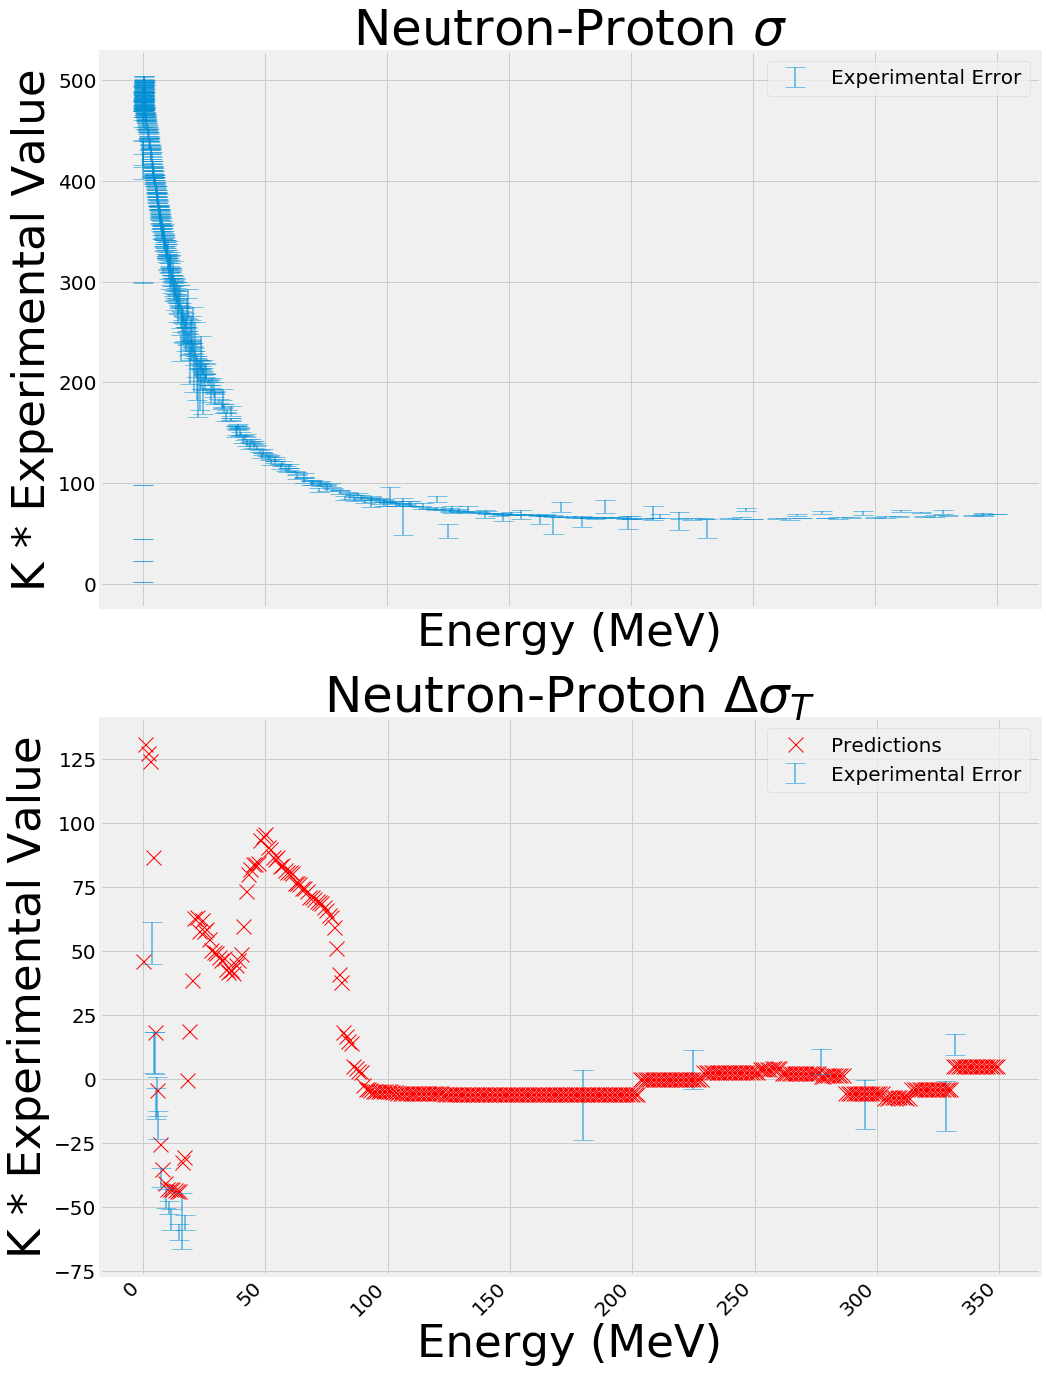

In [35]:
#read data file
data = pd.read_csv('CSV_files/np.sgt_and_sgtt.csv')
data.rename(columns={"statistical_error": "sigma"}, inplace=True)
#add k*exp column
change_np(data)
#remove columns that are not needed
data = data.drop(columns=['scattering_angle', 'K_sigma', 'sigma', 'systematic_error', 'normalization', 'experimental_value', 'reaction_type'])

#One-hot encode
features = pd.get_dummies(data)
# Labels are the values we want to predict
labels = np.array(features['K_experimental_value'])
# Remove the labels from the features
features = features.drop('K_experimental_value', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25)

rf = RandomForestRegressor(n_estimators= 1000)
# Train the model on training data
rf.fit(train_features, train_labels);

#make predictions 
#construct testing arrays
interval_size = 1
num_intervals = 350/interval_size
E_SGT = []
E_SGTT = []
E = list(range(0, 350 + int(interval_size/2), interval_size))
for value in range(0, 350 + int(interval_size/2), interval_size):
    E_SGT.append([value, 1, 0])
    E_SGTT.append([value, 0, 1])
#predict
#SGT
SGT_predictions = rf.predict(E_SGT)
#SGTT
SGTT_predictions = rf.predict(E_SGTT)

#generate arrays for plotting
np_sgt=pd.read_csv('CSV_files/np.sgt.csv')
np_sgt.rename(columns={"statistical_error": "sigma"}, inplace=True)
np_sgtt=pd.read_csv('CSV_files/np.sgtt.csv')
np_sgtt.rename(columns={"statistical_error": "sigma"}, inplace=True)
change_np(np_sgt)
change_np(np_sgtt)


#plot
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15,25))
fig.autofmt_xdate(rotation = 45)
#plot 1
#ax1.plot(E, SGT_predictions, 'rx', markersize=15,  alpha=1.0, label='Predictions')
#ax1.plot(np_sgt['energy'], np_sgt['K_experimental_value'], 'bo', alpha=0.3, label='Raw Experimental Data')
ax1.errorbar(np_sgt['energy'], np_sgt['K_experimental_value'], yerr=exp_err_sgt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Experimental Error')

ax1.tick_params(axis="y", labelsize=20); ax1.tick_params(axis="x", labelsize=20)
ax1.legend(loc='best', fontsize=20)
ax1.set_xlabel('Energy (MeV)', fontsize=45); ax1.set_ylabel('K * Experimental Value', fontsize=45); ax1.set_title('Neutron-Proton $\sigma$', fontsize=50)
#plot 2
ax2.plot(E, SGTT_predictions, 'rx', markersize=15, alpha=1.0, label='Predictions')
#ax2.plot(np_sgtt['energy'], np_sgtt['K_experimental_value'], 'bo', alpha=0.3, label='Raw Experimental Data')
ax2.errorbar(np_sgtt['energy'], np_sgtt['K_experimental_value'], yerr=exp_err_sgtt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Experimental Error')

ax2.tick_params(axis="y", labelsize=20); ax2.tick_params(axis="x", labelsize=20)
ax2.legend(loc='best', fontsize=20)
ax2.set_xlabel('Energy (MeV)', fontsize=45); ax2.set_ylabel('K * Experimental Value', fontsize=45); ax2.set_title('Neutron-Proton $\Delta \sigma_T$', fontsize=50)
#save figures
plt.savefig('Plots/predictions_no_phenom.pdf', format='pdf', bbox_inches='tight', transparent=True)

In [5]:
data.head(6)

,energy,observable,K_experimental_value
0,0.000001,SGT,2.243152
1,0.000100,SGT,22.491891
2,0.000400,SGT,44.863041
3,0.001970,SGT,98.070798
4,0.023645,SGT,299.288620
5,0.060000,SGT,414.056082


### Gaussian Factor

In [6]:
#organize experimental and phenomenological data for plotting
#read files
np_sgt=pd.read_csv('CSV_files/np.sgt.csv')
np_sgtt=pd.read_csv('CSV_files/np.sgtt.csv')
random_sgt=pd.read_csv('CSV_files/random.sgt.csv')
random_sgtt=pd.read_csv('CSV_files/random.sgtt.csv')
#add k*exp columns
random_sgt.rename(columns={' energy':'energy'}, inplace=True)
random_sgtt.rename(columns={' energy':'energy'}, inplace=True)
np_sgt.rename(columns={"statistical_error": "sigma"}, inplace=True)
np_sgtt.rename(columns={"statistical_error": "sigma"}, inplace=True)
change_np(np_sgt)
change_np(np_sgtt)
change_np(random_sgt)
change_np(random_sgtt)
#error bar arrays
rand_err_sgt=random_sgt['K_sigma'].tolist()
rand_err_sgtt=random_sgtt['K_sigma'].tolist()
exp_err_sgt=np_sgt['K_sigma'].tolist()
exp_err_sgtt=np_sgtt['K_sigma'].tolist()

In [43]:
def combine_data():
    ###create combined dataframe
    #random data
    random_data = pd.read_csv('CSV_files/random.sgt_and_sgtt.csv')
    random_data = random_data.drop(columns=["reaction_type"])
    random_data.rename(columns={' energy':'energy'}, inplace=True)
    random_data = random_data.drop(columns=['k'])
    #experimental data
    exp_data = pd.read_csv('CSV_files/np.sgt_and_sgtt.csv')
    exp_data = exp_data.drop(columns=['scattering_angle', 'normalization', 'reaction_type', 'systematic_error'])
    exp_data.rename(columns={"statistical_error": "sigma"}, inplace=True)
    #combine
    combined_data = pd.concat([random_data, exp_data], sort=True)
    #combined_data = pd.concat([random_data], sort=True)
    combined_data['k'] = combined_data.apply(lambda row: k_np(row.energy), axis=1)
    change_np(combined_data)
    return combined_data

def gauss_factor(combined_data, mu, sigma):
    ###create Gaussian factor 
    #Gaussian distribution
    combined_data['Gauss_factor'] = np.random.normal(mu, sigma, len(combined_data.energy))
    combined_data['Gauss_exp'] = combined_data.apply(lambda row: ((row.K_experimental_value) + (row.K_sigma*row.Gauss_factor)), axis=1)
    #remove unecessary columns
    combined_data = combined_data.drop(columns=['K_experimental_value', 'K_sigma', 'experimental_value', 'k', 'sigma', 'Gauss_factor'])
    return combined_data

In [44]:
################################ ATTEMPT 2 ##################################
#make dataframe
#index will be value of energy (use df.set_index(E))
#dynamically create new column for each set of predictions
#create separate lists for the average and variance of each row 
#maybe that will work? 


In [45]:
combined_data=combine_data()
combined_data=gauss_factor(combined_data,0,1)
combined_data.head(4)

,energy,observable,Gauss_exp
0,238.226430,SGT,65.293314
1,35.918331,SGT,164.453812
2,181.784790,SGT,66.436252
3,264.710330,SGT,65.899665


In [103]:
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
###  PARAMETERS TO BE CHANGED ARE ALL IN THIS CELL  ###
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################

#define number of times to make predictions with different gaussian factor
n_max=50 

#define interval step size for predictions 
###MUST BE INTEGER >=1 AND FACTOR OF 350
interval_size = 25 #MeV  

#define number of trees used in random forest 
num_trees=1000

#define test size
test_data_size = 0.25 # % of total amount of data

Predictions computed with n = 1 
Predictions computed with n = 2 
Predictions computed with n = 3 
Predictions computed with n = 4 
Predictions computed with n = 5 
Predictions computed with n = 6 
Predictions computed with n = 7 
Predictions computed with n = 8 
Predictions computed with n = 9 
Predictions computed with n = 10 
Predictions computed with n = 11 
Predictions computed with n = 12 
Predictions computed with n = 13 
Predictions computed with n = 14 
Predictions computed with n = 15 
Predictions computed with n = 16 
Predictions computed with n = 17 
Predictions computed with n = 18 
Predictions computed with n = 19 
Predictions computed with n = 20 
Predictions computed with n = 21 
Predictions computed with n = 22 
Predictions computed with n = 23 
Predictions computed with n = 24 
Predictions computed with n = 25 
Predictions computed with n = 26 
Predictions computed with n = 27 
Predictions computed with n = 28 
Predictions computed with n = 29 
Predictions computed wi

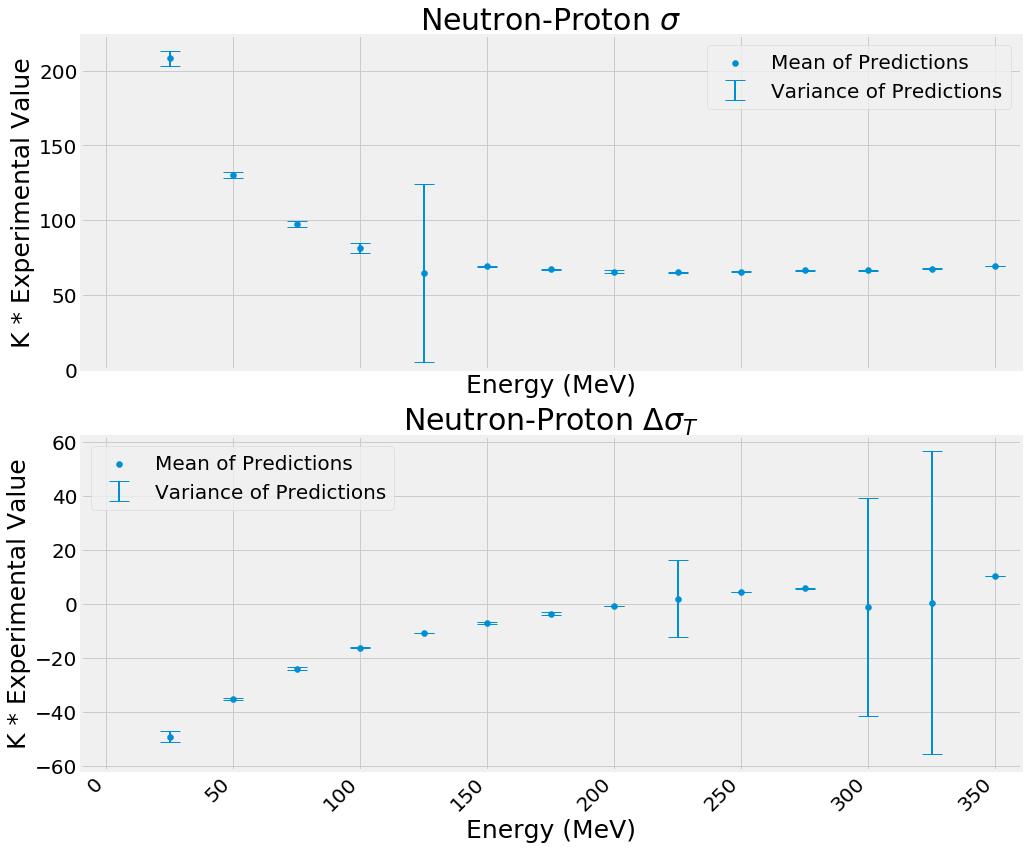

In [104]:
#start timer
gauss_time=time.time()

#define interval specifications for prediction arrays
E_max=350
num_intervals = E_max/interval_size
E_index = list(range(interval_size, E_max + int(interval_size), interval_size)) ###this will be index of dataframe

df_SGT=pd.DataFrame({'Energy': E_index})
df_SGTT=pd.DataFrame({'Energy': E_index})


for n in range(1,n_max+1):
    ###create combined dataframe
    combined_data=combine_data()
    ###create Gaussian factor 
    combined_data=gauss_factor(combined_data, 0, 1)

    ###train
    #One-hot encode
    features = pd.get_dummies(combined_data)
    # Labels are the values we want to predict
    labels = np.array(features['Gauss_exp'])
    # Remove the labels from the features
    features = features.drop('Gauss_exp', axis = 1)
    # Saving feature names for later use
    feature_list = list(features.columns)
    # Convert to numpy array
    features = np.array(features)
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = test_data_size)
    rf = RandomForestRegressor(n_estimators= num_trees)
    # Train the model on training data
    rf.fit(train_features, train_labels);

    ###make predictions 
    #construct testing arrays
    E_SGT = []
    E_SGTT = []
    E = list(range(interval_size, E_max + int(interval_size), interval_size))
    for value in E:
        E_SGT.append([value, 1, 0])
        E_SGTT.append([value, 0, 1])
    #predict
    #SGT
    SGT_predictions = rf.predict(E_SGT)
    #SGTT
    SGTT_predictions = rf.predict(E_SGTT)
    
    #add column to dataframes
    df_SGT["SGT_Preds_%s"%('%.0f'%n)] = SGT_predictions
    df_SGTT["SGTT_Preds_%s"%('%.0f'%n)] = SGTT_predictions
    
    #print completed message
    print("Predictions computed with n = %s "%('%.0f'%n))

#predictions array     
df_SGT = df_SGT.drop("Energy", axis=1)
df_SGT['Prediction Mean'] = df_SGT.mean(axis=1)
df_SGT['Prediction Variance'] = df_SGT.var(axis=1)
df_SGTT = df_SGTT.drop("Energy", axis=1)
df_SGTT['Prediction Mean'] = df_SGTT.mean(axis=1)
df_SGTT['Prediction Variance'] = df_SGTT.var(axis=1)

df_SGT.head(4)

#plot 
#figure specs
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15,15))
fig.autofmt_xdate(rotation = 45)

#plot 1 - SGT
ax1.scatter(E, df_SGT['Prediction Mean'], label='Mean of Predictions')
ax1.errorbar(E, df_SGT['Prediction Mean'], yerr=df_SGT['Prediction Variance'], linestyle='none', capsize=10, elinewidth=2, label='Variance of Predictions')
#ax1.plot(np_sgt['energy'], np_sgt['K_experimental_value'], 'bo', alpha=0.3, label='Raw Experimental Data')
#ax1.plot(random_sgt['energy'], random_sgt['K_experimental_value'], 'k+', markersize=15, label='Phenomenological Data')
#ax1.errorbar(np_sgt['energy'], np_sgt['K_experimental_value'], yerr=exp_err_sgt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Experimental Error')
#ax1.errorbar(random_sgt['energy'], random_sgt['K_experimental_value'], yerr=rand_err_sgt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Phenomenological Error')

ax1.tick_params(axis="y", labelsize=20)
ax1.tick_params(axis="x", labelsize=20)
ax1.legend(loc='best', fontsize=20)
ax1.set_xlabel('Energy (MeV)', fontsize=25)
ax1.set_xlim([-10,360])
ax1.set_ylim(bottom=0)
ax1.set_ylabel('K * Experimental Value', fontsize=25)
ax1.set_title('Neutron-Proton $\sigma$', fontsize=30)

#plot 2 - SGTT
ax2.scatter(E, df_SGTT['Prediction Mean'], label='Mean of Predictions')
ax2.errorbar(E, df_SGTT['Prediction Mean'], yerr=df_SGTT['Prediction Variance'], linestyle='none', capsize=10, elinewidth=2, label='Variance of Predictions')
#ax2.plot(np_sgtt['energy'], np_sgtt['K_experimental_value'], 'bo', alpha=0.3, label='Raw Experimental Data')
#ax2.plot(random_sgtt['energy'], random_sgtt['K_experimental_value'], 'k+', markersize=15, label='Phenomenological Data')
#ax2.errorbar(np_sgtt['energy'], np_sgtt['K_experimental_value'], yerr=exp_err_sgtt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Experimental Error')
#ax2.errorbar(random_sgtt['energy'], random_sgtt['K_experimental_value'], yerr=rand_err_sgtt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Phenomenological Error')

ax2.tick_params(axis="y", labelsize=20)
ax2.tick_params(axis="x", labelsize=20)
ax2.legend(loc='best', fontsize=20)
ax2.set_xlabel('Energy (MeV)', fontsize=25)
ax2.set_xlim([-10,360])
ax2.set_ylabel('K * Experimental Value', fontsize=25)
ax2.set_title('Neutron-Proton $\Delta \sigma_T$', fontsize=30)

#save figures
plt.savefig('Plots/predictions_with_gauss.pdf', format='pdf', bboxinches='tight', transparent=True)

#print elapsed time
timer(gauss_time)

In [105]:
df_SGT['Energy']=E
df_SGT.set_index("Energy", inplace = True)
df_SGT

,SGT_Preds_1,SGT_Preds_2,SGT_Preds_3,SGT_Preds_4,SGT_Preds_5,SGT_Preds_6,SGT_Preds_7,SGT_Preds_8,SGT_Preds_9,SGT_Preds_10,...,SGT_Preds_43,SGT_Preds_44,SGT_Preds_45,SGT_Preds_46,SGT_Preds_47,SGT_Preds_48,SGT_Preds_49,SGT_Preds_50,Prediction Mean,Prediction Variance
Energy,,,,,,,,,,,,,,,,,,,,,
25,210.987429,202.780201,208.050988,209.458043,208.641210,209.368574,208.540762,208.567750,210.689815,211.027430,...,210.307321,208.098766,205.756635,208.404616,210.215424,208.546905,207.200445,202.395543,208.480629,4.999833
50,131.334705,128.935272,130.741550,131.304288,128.984251,132.200192,132.162416,128.886890,128.120098,128.485553,...,127.294820,130.946009,131.294412,131.344048,131.168948,130.758131,130.652458,131.650020,130.048177,1.990627
75,97.680600,97.907223,96.573399,96.528082,97.825009,97.948357,97.228059,96.041245,96.702824,96.470388,...,94.506209,96.014401,96.438119,97.729804,97.929503,97.751375,98.075441,97.813910,97.159900,2.181652
100,78.265511,80.596194,82.004164,77.246414,79.998844,79.398190,79.421277,82.740227,82.088814,82.068832,...,80.288194,77.867085,81.702637,79.688035,82.557057,84.707759,83.509296,78.567031,81.007671,3.254565
125,64.100276,74.412226,63.850098,66.373012,57.493887,65.451286,62.631470,58.495253,74.602177,56.019758,...,74.491128,64.946319,52.657770,61.986740,73.632449,74.624868,55.862288,57.720795,64.628102,59.741351
150,68.732985,68.804122,68.286574,69.762949,68.429236,68.607756,68.784167,69.147422,68.424546,67.823780,...,68.203332,68.610224,68.660833,69.499839,69.177489,69.290975,68.465869,69.802933,68.886534,0.245226
175,66.707429,66.672900,67.037855,66.900858,66.981698,66.917361,66.964099,66.978964,66.918619,66.812986,...,67.372357,66.489392,66.983324,66.287027,66.617823,67.077264,66.960811,66.775645,66.803903,0.142382
200,65.433951,65.347451,64.430718,65.592771,65.811543,66.771692,63.223898,65.468367,66.480546,64.997494,...,64.083011,65.490623,65.255588,64.628682,64.255787,65.207921,65.225451,65.298461,65.313399,0.841215
225,63.925648,65.335746,64.545719,64.653878,64.772416,64.205472,64.543218,63.690983,64.400583,64.466010,...,65.224778,64.939216,63.916895,65.021656,64.218736,63.762260,64.529291,65.238050,64.779645,0.304658


In [106]:
df_SGTT['Energy']=E
df_SGTT.set_index("Energy", inplace = True)
df_SGTT

,SGTT_Preds_1,SGTT_Preds_2,SGTT_Preds_3,SGTT_Preds_4,SGTT_Preds_5,SGTT_Preds_6,SGTT_Preds_7,SGTT_Preds_8,SGTT_Preds_9,SGTT_Preds_10,...,SGTT_Preds_43,SGTT_Preds_44,SGTT_Preds_45,SGTT_Preds_46,SGTT_Preds_47,SGTT_Preds_48,SGTT_Preds_49,SGTT_Preds_50,Prediction Mean,Prediction Variance
Energy,,,,,,,,,,,,,,,,,,,,,
25,-47.858014,-48.892986,-52.087410,-49.531697,-50.036387,-47.753615,-49.869909,-50.141997,-49.247976,-50.217164,...,-49.358400,-48.786022,-49.641314,-49.007357,-48.730427,-52.868559,-49.139076,-48.336647,-49.268764,2.041749
50,-34.416248,-35.296219,-35.663431,-34.675458,-34.870381,-34.693583,-35.559114,-35.228001,-35.386484,-34.782096,...,-34.338764,-34.791138,-34.882546,-34.986347,-34.682074,-35.057552,-34.817478,-35.065355,-35.214274,0.325309
75,-23.801367,-24.300082,-23.239775,-23.845304,-23.920880,-23.892711,-25.297422,-23.770916,-23.657935,-23.534029,...,-25.647510,-24.259461,-23.480642,-24.432183,-23.590113,-23.637183,-23.535912,-25.461034,-24.089266,0.664050
100,-16.233551,-16.379541,-16.281337,-16.079376,-16.545646,-16.108798,-15.721136,-16.125970,-16.381484,-16.289763,...,-16.131949,-16.097099,-16.277846,-16.040033,-16.532248,-16.193343,-16.456723,-16.364155,-16.245666,0.072794
125,-11.010467,-11.139187,-11.049677,-11.206650,-11.287556,-11.063964,-11.164748,-11.021053,-11.213090,-10.810004,...,-11.055811,-11.083210,-11.090877,-11.136498,-11.034994,-10.929392,-11.053808,-11.029001,-11.025219,0.022015
150,-8.615452,-7.253996,-7.628965,-7.585012,-6.410124,-6.229546,-6.682306,-7.459581,-6.173612,-7.079316,...,-7.263103,-7.281805,-6.398390,-7.589166,-8.287643,-7.491609,-7.715262,-7.241610,-7.181274,0.371844
175,-5.446082,-4.493699,-3.964295,-3.619673,-3.479002,-4.111356,-3.196510,-2.990446,-3.738092,-3.794995,...,-4.770358,-3.693780,-3.428909,-3.430608,-3.185858,-3.821025,-3.578746,-3.828223,-3.753333,0.565850
200,-1.280298,-1.095651,-0.971073,-0.763306,-0.882919,-1.098863,-0.884647,-1.189669,-0.804356,-0.941699,...,-1.020268,-0.907161,-1.132013,-0.798226,-0.818521,-0.935485,-0.976789,-0.781741,-0.974200,0.018118
225,4.701209,1.746489,1.954692,3.253978,2.568929,-1.626603,1.309512,1.674784,-1.141187,-5.539998,...,-1.575057,4.895398,-2.401883,3.861736,8.191442,-10.120955,4.176796,-2.105458,1.766700,14.268821


#### Gaussian Done 1 Time 

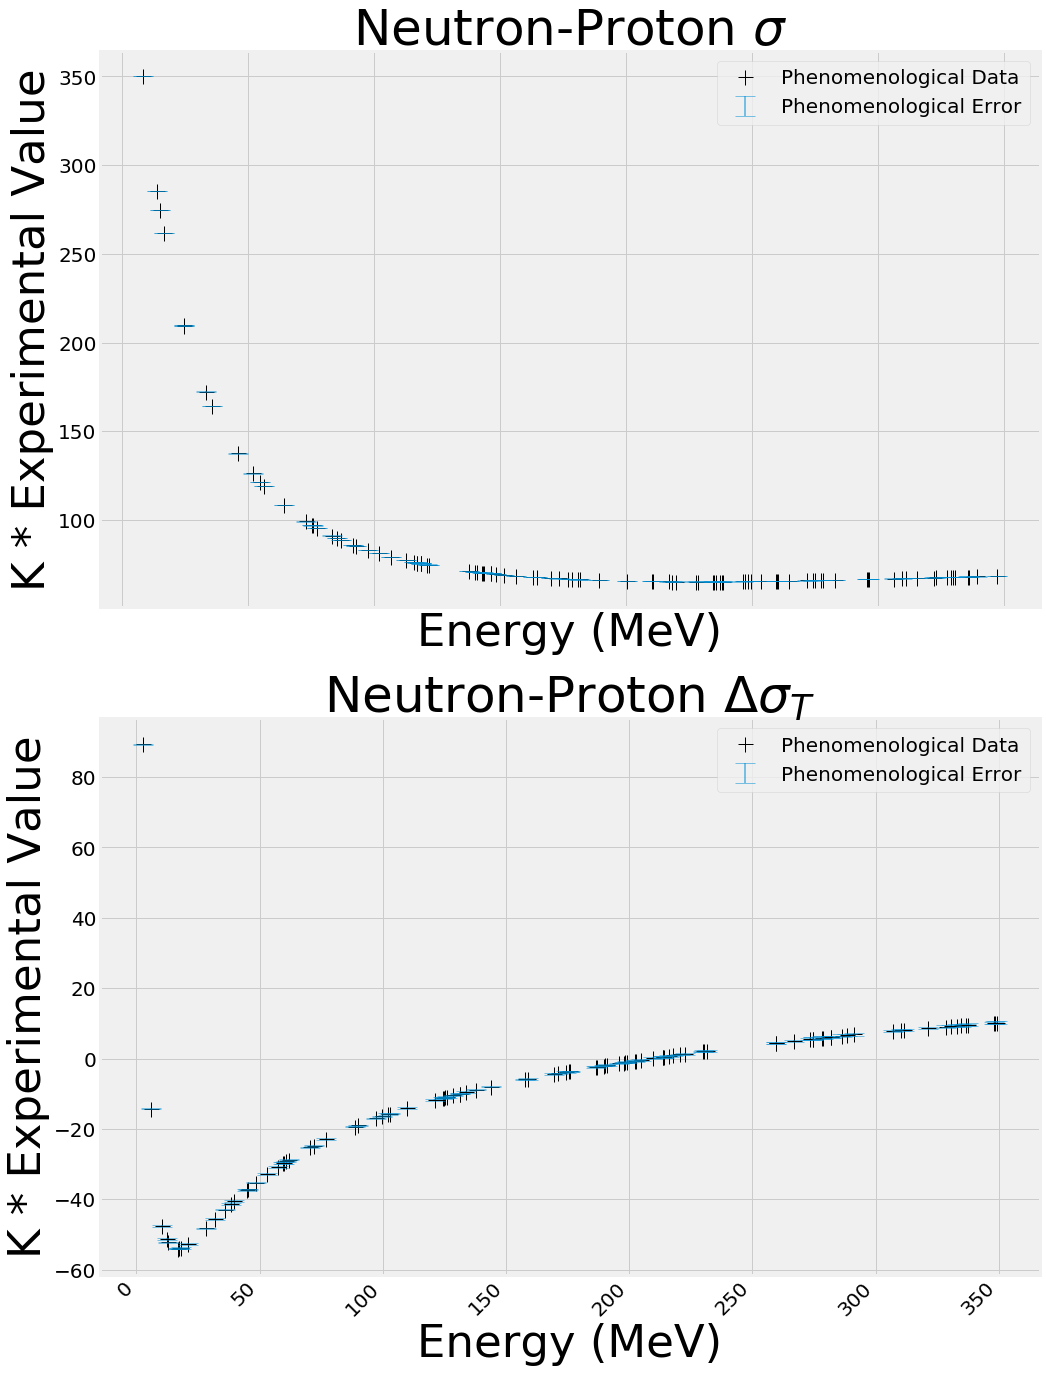

In [36]:
#One-hot encode
features = pd.get_dummies(combined_data)
# Labels are the values we want to predict
labels = np.array(features['Gauss_exp'])
# Remove the labels from the features
features = features.drop('Gauss_exp', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25)

rf = RandomForestRegressor(n_estimators= 1000)
# Train the model on training data
rf.fit(train_features, train_labels);

#make predictions 
#construct testing arrays
interval_size = 1
num_intervals = 350/interval_size
E_SGT = []
E_SGTT = []
E = list(range(0, 350 + int(interval_size), interval_size))
for value in range(0, 350 + int(interval_size), interval_size):
    E_SGT.append([value, 1, 0])
    E_SGTT.append([value, 0, 1])
#predict
#SGT
SGT_predictions = rf.predict(E_SGT)
#SGTT
SGTT_predictions = rf.predict(E_SGTT)


#plot
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15,25))
fig.autofmt_xdate(rotation = 45)
#plot 1
#ax1.plot(E, SGT_predictions, 'rx', markersize=15,  alpha=1.0, label='Predictions')
#ax1.plot(np_sgt['energy'], np_sgt['K_experimental_value'], 'bo', alpha=0.3, label='Raw Experimental Data')
ax1.plot(random_sgt['energy'], random_sgt['K_experimental_value'], 'k+', markersize=15, label='Phenomenological Data')
#ax1.errorbar(np_sgt['energy'], np_sgt['K_experimental_value'], yerr=exp_err_sgt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Experimental Error')
ax1.errorbar(random_sgt['energy'], random_sgt['K_experimental_value'], yerr=rand_err_sgt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Phenomenological Error')
ax1.tick_params(axis="y", labelsize=20); ax1.tick_params(axis="x", labelsize=20)
ax1.legend(loc='best', fontsize=20)
ax1.set_xlabel('Energy (MeV)', fontsize=45); ax1.set_ylabel('K * Experimental Value', fontsize=45); ax1.set_title('Neutron-Proton $\sigma$', fontsize=50)

#plot 2
#ax2.plot(E, SGTT_predictions, 'rx', markersize=15, alpha=1.0, label='Predictions')
#ax2.plot(np_sgtt['energy'], np_sgtt['K_experimental_value'], 'bo', alpha=0.3, label='Raw Experimental Data')
ax2.plot(random_sgtt['energy'], random_sgtt['K_experimental_value'], 'k+', markersize=15, label='Phenomenological Data')
#ax2.errorbar(np_sgtt['energy'], np_sgtt['K_experimental_value'], yerr=exp_err_sgtt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Experimental Error')
ax2.errorbar(random_sgtt['energy'], random_sgtt['K_experimental_value'], yerr=rand_err_sgtt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Phenomenological Error')
ax2.tick_params(axis="y", labelsize=20); ax2.tick_params(axis="x", labelsize=20)
ax2.legend(loc='best', fontsize=20)
ax2.set_xlabel('Energy (MeV)', fontsize=45); ax2.set_ylabel('K * Experimental Value', fontsize=45); ax2.set_title('Neutron-Proton $\Delta \sigma_T$', fontsize=50)
#save figures
plt.savefig('Plots/predictions_with_phenom.pdf', format='pdf', bbox_inches='tight', transparent=True)